In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
wifi_filename = "wifi_data.csv"
wifi_data = pd.read_csv(wifi_filename)
wifi_data.columns.values

array(['version', 'buiildingId', 'x', 'y', 'floor', 'SSID', 'level',
       'timestamp', 'frequency', 'BSSID', 'capabilities', 'uploadedAt'],
      dtype=object)

In [111]:
f_1 = wifi_data[wifi_data['floor'] == -1]
f0 = wifi_data[wifi_data['floor'] == 0]

In [113]:
global_x_min = wifi_data['x'].min()
global_x_max = wifi_data['x'].max()
global_y_min = wifi_data['y'].min()
global_y_max = wifi_data['y'].max()

In [114]:
def remove_ap_by_occurances(data,threshold):
    ssid_counts = data['SSID'].value_counts()
    common_ssids = ssid_counts[ssid_counts >= threshold].index
    filtered_wifi_data = data[data['SSID'].isin(common_ssids)]
    return filtered_wifi_data

def remove_macs_by_occurances(data,threshold):
    ssid_counts = data['BSSID'].value_counts()
    common_ssids = ssid_counts[ssid_counts >= threshold].index
    filtered_wifi_data = data[data['BSSID'].isin(common_ssids)]
    return filtered_wifi_data

def remove_all_weak_rss(data,threshold):
    filtered_data = data[data['level'] >= threshold]
    return filtered_data

def remove_hidden_ssid(data):
    title = "(hidden SSID)"
    filtered_data = data[data['SSID'] != title]
    return filtered_data


def get_ssid_map_area(data,ssid):
    filtered_data = data[data['SSID'] == ssid]
    x_min = filtered_data['x'].min()
    x_max = filtered_data['x'].max()
    y_min = filtered_data['y'].min()
    y_max = filtered_data['y'].max()
    return (
        x_min,
        x_max,
        y_min,
        y_max,
    )

def plot(data,ssid):
    pass
    

In [121]:
wifi_data['level'].min(),wifi_data['level'].max()

(-101, -7)

In [122]:
min_ap_occurances_threhsold = 200
rss_threshold = -75

data = remove_ap_by_occurances(wifi_data,min_ap_occurances_threhsold)
data = remove_hidden_ssid(data)
data = remove_all_weak_rss(data,rss_threshold)
data['SSID'].value_counts()

SSID
Afeka-Staff        898
Afeka-Wifi-Open    820
Afeka-Students     814
Name: count, dtype: int64

In [123]:
data['level'].min(),data['level'].max()

(-75, -8)

In [131]:
bins = 50
vmax = 8
vmin = 1
figsize = (4,3)

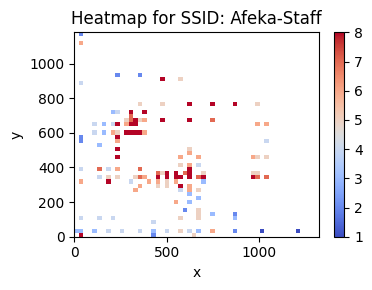

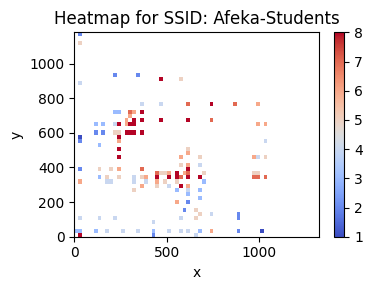

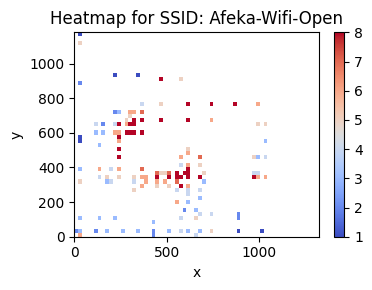

In [132]:
grouped_data = data.groupby('SSID')
for ssid, group in grouped_data:
    plt.figure(figsize=figsize)
    sns.histplot(data=group, x='x', y='y', bins=bins, cmap='coolwarm', cbar=True,
                 vmin=vmin, vmax=vmax)
    plt.title(f'Heatmap for SSID: {ssid}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(global_x_min, global_x_max)
    plt.ylim(global_y_min, global_y_max)
    plt.tight_layout()
    plt.show() 

In [94]:
len(data.groupby(["BSSID"]))

289

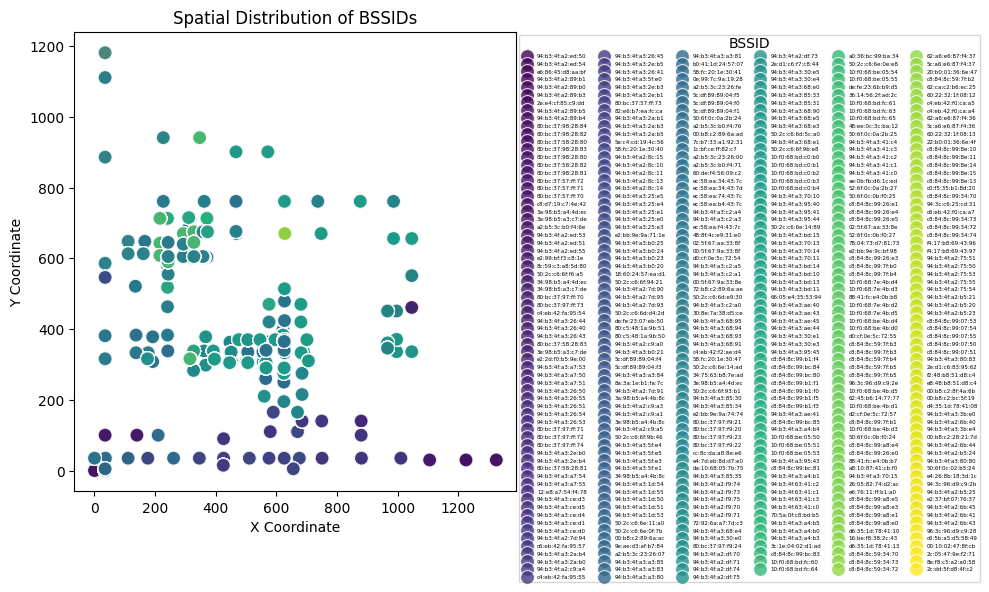

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=wifi_data, x='x', y='y', hue='BSSID', palette='viridis', legend='full', s=100, alpha=0.8)
plt.title('Spatial Distribution of BSSIDs')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='BSSID', loc='upper left', bbox_to_anchor=(1, 1),fontsize=4,ncols=6)
plt.tight_layout()
plt.show()

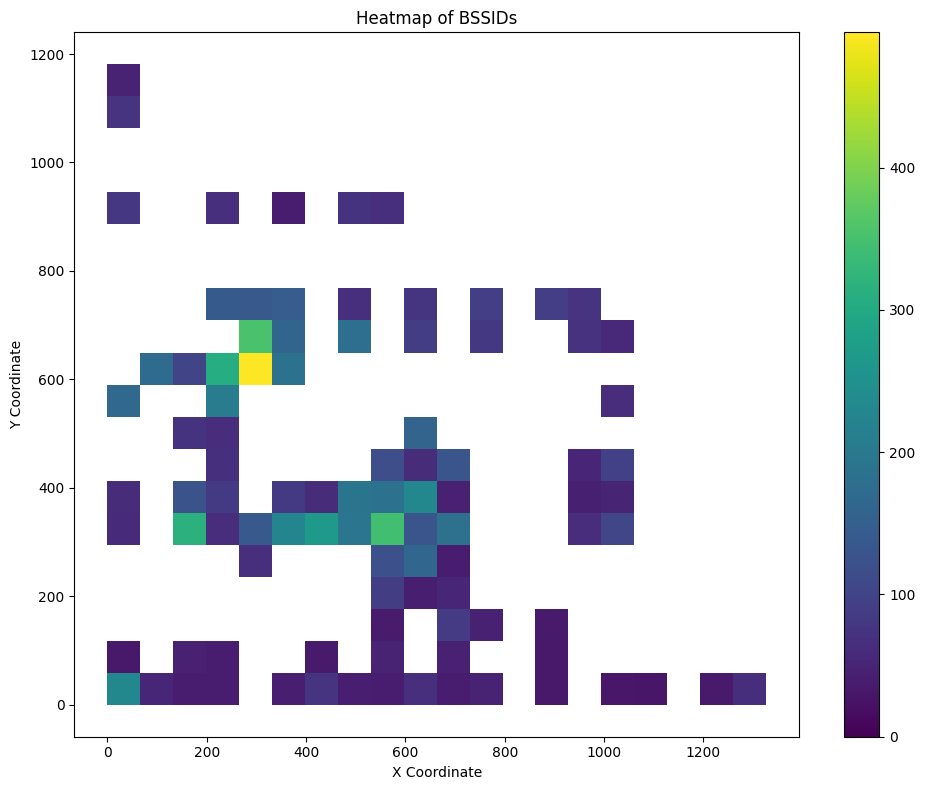

In [96]:
plt.figure(figsize=(10, 8))
sns.histplot(data=wifi_data, x='x', y='y', bins=20, cmap='viridis', cbar=True)
plt.title('Heatmap of BSSIDs')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()
plt.show()

In [97]:
ssid_bssid_counts = data.groupby(['SSID', 'BSSID']).size().reset_index(name='Count')
ssid_bssid_counts

,SSID,BSSID,Count
0,(hidden SSID),02:5f:67:aa:33:8e,15
1,(hidden SSID),02:5f:67:aa:33:8f,11
2,(hidden SSID),10:f0:68:7e:4b:d3,4
3,(hidden SSID),10:f0:68:bd:c0:b1,14
4,(hidden SSID),10:f0:68:bd:c0:b2,12
...,...,...,...
284,Afeka-Wifi-Open,c8:84:8c:99:8e:10,9
285,Afeka-Wifi-Open,c8:84:8c:99:a8:e0,25
286,Afeka-Wifi-Open,c8:84:8c:99:b1:f0,62
287,Afeka-Wifi-Open,c8:84:8c:99:bc:80,82


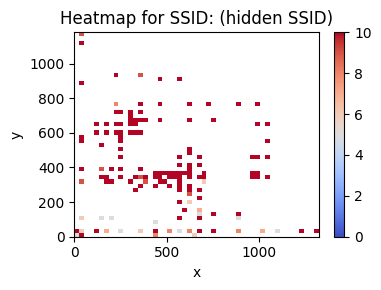

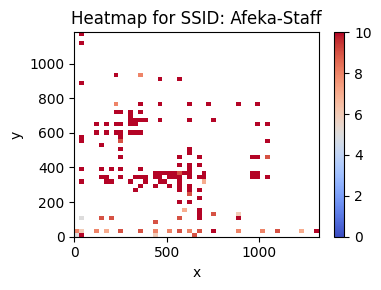

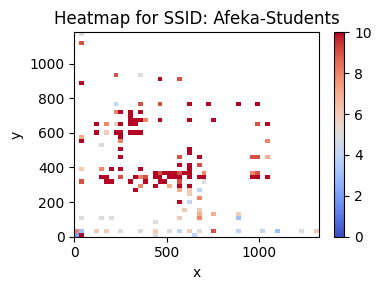

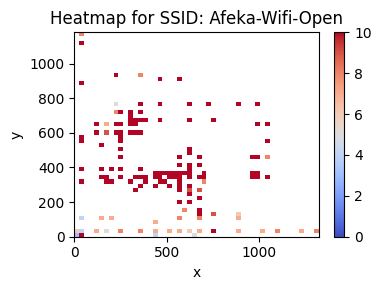

In [98]:
grouped_data = data.groupby('SSID')
for ssid, group in grouped_data:
    plt.figure(figsize=figsize)
    sns.histplot(data=group, x='x', y='y', bins=bins, cmap='coolwarm', cbar=True,
                 vmin=vmin, vmax=vmax)
    plt.title(f'Heatmap for SSID: {ssid}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(global_x_min, global_x_max)
    plt.ylim(global_y_min, global_y_max)
    plt.tight_layout()
    plt.show() 